In [120]:
import numpy as np
import math

class SimpleAgentModel:
    class Donators:
        
        def __init__(self):
            self.med_coef = 0
            self.adv_coef = 0
            self.org_pref = 0
            self.reset()
            
        def reset(self):
            self.med_coef = np.random.beta(2, 2, 100)
            self.adv_coef = np.zeros(100, np.float64)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] > half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i] 
            self.org_pref = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            
    class Patients:
        def __init__(self):
            self.med_coef = 0  
            self.adv_coef = 0               
            self.org_pref = 0
            self.choice = 0
            self.p_survival = 0 
            self.visited = 0
            self.budget = 0
            self.count_cured = 0
            self.reset()
            
        def reset(self):

            self.med_coef = np.random.beta(2, 2, 100)  #  Какие параметры бета-распредления выставить?
            self.adv_coef = np.zeros(100, np.float64)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] < half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i] 
                   
            self.org_pref = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            self.choice = np.zeros(100, np.int8)
            self.p_survival = np.random.beta(2, 2, 100)  #  попробовать другие коэф
            self.visited = np.zeros((100, 10), bool)
            self.budget = np.zeros(100, np.int8)
            self.count_cured = np.int8(0)
            
        def new_patient(self, i):
            for j in range(10):
                self.visited[i][j] = False
            self.p_survival[i] = np.random.beta(2, 2)
            self.med_coef[i] = np.random.beta(2, 2)
            if self.med_coef[i] < np.float64(0.5):
                self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
            else:
                self.adv_coef[i] = 1 - self.med_coef[i]
            
    class Organizations:
        def __init__(self):
            self.budget = 0
            self.med_budget = 0
            self.adv_budget = 0
            self.med_coef = 0
            self.is_lose = 0
            self.patients = 0
            self.laps = 0
            self.saved_lives = 0
            self.all_patients = 0
            self.reset()
            
        def reset(self):
            self.budget = np.zeros(10, np.int8)
            self.med_budget = np.zeros(10, np.int8)
            self.adv_budget = np.zeros(10, np.int8)
            self.med_coef = np.random.beta(2, 2, 10)  #   Какие параметры бета-распредления выставить?
            self.is_lose = np.zeros(10, bool)
            self.patients = [[] for i in range(10)]
            self.laps = np.zeros(10, np.int8)
            self.saved_lifes = np.zeros(10, np.int16)
            self.all_patients = np.zeros(10, np.int16)
            
    
    def __init__(self):
        self.donators = SimpleAgentModel.Donators()
        self.patients = SimpleAgentModel.Patients()
        self.organizations = SimpleAgentModel.Organizations()
        
    def donation(self):
        for i in range(100): 
            ind = np.argmax(self.donators.org_pref[i]) 
            self.organizations.budget[ind] += 1        
            
    def budget_med_or_adv(self):                    #  Сделать долевым!!  
        for i in range(10):
            if self.organizations.budget[i] == 0:
                self.organizations.is_lose[i] = True
            else:
                self.organizations.laps[i] += 1
                self.organizations.med_budget[i] = np.int8(self.organizations.budget[i] * self.organizations.med_coef[i])
                self.organizations.adv_budget[i] = self.organizations.budget[i] - self.organizations.med_budget[i]
                self.organizations.budget[i] = 0
        #print(f'{self.organizations.med_budget = }\n{self.organizations.adv_budget = }')

    def choose_organization(self):  
        for i in range(100):
            for j in range(10):
                if self.patients.visited[i][j] or self.organizations.is_lose[j]:
                    self.patients.org_pref[i][j] = -100
                    continue
                a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                self.patients.org_pref[i][j] = np.random.normal(a, 9, 1)[0]
            ind = np.argmax(self.patients.org_pref[i]) 
            if self.patients.org_pref[i][ind] == -100:
                for j in range(10):
                    self.patients.visited[i][j] = False
                    if not self.organizations.is_lose[j]:
                        a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                        self.patients.org_pref[i][j] = np.random.normal(a, 9, 1)[0]
                ind = np.argmax(self.patients.org_pref[i])
                   
            self.patients.visited[i][ind] = True
            self.patients.choice[i] = ind
            self.organizations.all_patients[ind] += 1
            self.organizations.patients[ind].append(i)
                                                                                                                                                
    def budget_between_patient(self): #  Может ли организация не принять?
        for i in range(10):
            if (self.organizations.is_lose[i]):
                continue
            survive = [self.patients.p_survival[self.organizations.patients[i][j]] for j in range(len(self.organizations.patients[i]))]
            surv_sum = sum(survive)
            proportion = [prob / surv_sum for prob in survive]
            for j in range(len(self.organizations.patients[i])):
                ind = self.organizations.patients[i][j]
                self.patients.budget[ind] = proportion[j] * self.organizations.med_budget[i]            
            self.organizations.patients[i] = []
        
    def survival(self):                 #  поменять коэффициенты в ???
        for i in range(100):            #  logit ~ (0.5, 1) - p выживаемости. 
                                        #  У нас в любом случае высокая вероятность выжить!!

            s_i = (1 / (1 + math.pow(math.e, -(self.patients.p_survival[i] + 0.01 * self.patients.budget[i]) )))
            
            if np.random.binomial(1, s_i): #  Пациент вылечился (Биномиальное распределение)
                self.patients.count_cured += 1
                self.patients.new_patient(i)
                self.organizations.saved_lifes[self.patients.choice[i]] += 1
        
    def set_new_preferences(self):
        for i in range(100):
            for j in range(10):
                if self.organizations.is_lose[j]:
                    self.donators.org_pref[i][j] = -100
                    continue
                a = self.donators.med_coef[i] * self.organizations.med_budget[j] + self.donators.adv_coef[i] * self.organizations.adv_budget[j]
                self.donators.org_pref[i][j] = np.random.normal(a, 9)
        self.organizations.budget = np.zeros(10, np.int8)
        self.organizations.med_budget = np.zeros(10, np.int8)
        self.organizations.adv_budget = np.zeros(10, np.int8)
        
    
    def lap(self):
        self.donation()
        #print('Budgets of org:', end = ' ')
        #for i in range(10):
        #    print(self.organizations.budget[i], end = ', ')
        #print()
        
        self.budget_med_or_adv()
        self.choose_organization()
        
        #print(f'Количество пациентов организации:', end = ' ')
        #for i in range(10):
        #    print(len(self.organizations.patients[i]), end = ', ')
        #print()
        self.budget_between_patient()
        self.survival()
        #print(f'Количество вылечившихся: {self.patients.count_cured}')
        self.set_new_preferences()
        
    def simulation(self):
        self.donators.reset()
        self.patients.reset()
        self.organizations.reset()
        i = 0
        while True:
            i += 1
            self.lap()
            if sum(self.organizations.is_lose == True) == 9:
                winner_ind = 0
                for j in range(10):
                    if not self.organizations.is_lose[j]:
                        winner_ind = j
                        break
                print(f'laps: {i}, saved: {self.patients.count_cured}, per_lap: {self.patients.count_cured / i}')
                return i, self.organizations.laps, self.organizations.med_coef, self.organizations.saved_lifes, self.organizations.all_patients, winner_ind
                
        
        

laps: 6, saved: 378, per_lap: 63.0
laps: 6, saved: 354, per_lap: 59.0
laps: 7, saved: 429, per_lap: 61.285714285714285
laps: 8, saved: 490, per_lap: 61.25
laps: 7, saved: 413, per_lap: 59.0
laps: 6, saved: 358, per_lap: 59.666666666666664
laps: 7, saved: 446, per_lap: 63.714285714285715
laps: 7, saved: 419, per_lap: 59.857142857142854
laps: 7, saved: 435, per_lap: 62.142857142857146
laps: 6, saved: 375, per_lap: 62.5
laps: 7, saved: 430, per_lap: 61.42857142857143
laps: 10, saved: 648, per_lap: 64.8
laps: 5, saved: 308, per_lap: 61.6
laps: 9, saved: 553, per_lap: 61.44444444444444
laps: 6, saved: 379, per_lap: 63.166666666666664
laps: 6, saved: 350, per_lap: 58.333333333333336
laps: 7, saved: 436, per_lap: 62.285714285714285
laps: 6, saved: 378, per_lap: 63.0
laps: 7, saved: 427, per_lap: 61.0
laps: 8, saved: 506, per_lap: 63.25
laps: 6, saved: 392, per_lap: 65.33333333333333
laps: 8, saved: 488, per_lap: 61.0
laps: 7, saved: 422, per_lap: 60.285714285714285
laps: 9, saved: 557, per_la

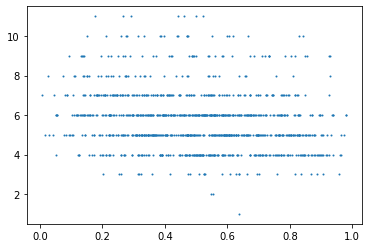

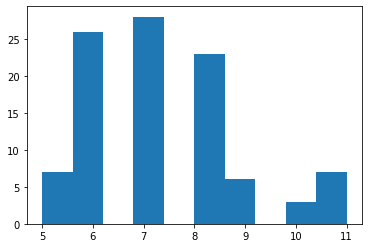

In [121]:
from matplotlib import pyplot as plt
from statistics import mean

total_laps = []
total_med_coef = []
total_saved_lifes = []
total_patients = []

game_end = []

winner_med = []
#winner_saved = []
winner_saved_fraction = []
#winner_saved_per_lap = []

Model = SimpleAgentModel()

for i in range(100):
    end, laps, med_coef, saved_lifes, total_pat, win_ind = Model.simulation()
    total_laps.extend(laps)
    total_med_coef.extend(med_coef)
    total_saved_lifes.extend(saved_lifes)
    total_patients.extend(total_pat)
    
    game_end.append(end)
    
    winner_med.append(med_coef[win_ind])
    #winner_saved.append(saved_lifes[win_ind])
    winner_saved_fraction.append(saved_lifes[win_ind] / total_pat[win_ind])
    #winner_saved_per_lap.append(saved_lifes[win_ind] / laps[win_ind] / total_pat[win_ind])

#lifes_per_lap = [total_saved_lifes[i] / total_laps[i] / total_patients[i] for i in range(len(total_patients))]
saved_fraction = [total_saved_lifes[i] / total_patients[i] for i in range(len(total_patients))]
    
print(f'Average med_coef: {round(mean(total_med_coef), 4)}')     #  0.4981   0.4997
print(f'Average winner med_coef: {round(mean(winner_med), 4)}')  #  0.5219   0.5385

print(f'Average saved fraction: {round(mean(saved_fraction), 4)}')         
print(f'Average winner saved fraction: {round(mean(winner_saved_fraction), 4)}')

print(f'\nAverage end_lap: {round(mean(game_end), 4)}')

print(f'\nStandart deviation med_coef: {round(np.std(total_med_coef), 4)}')     #  0.2249 
print(f'Standart deviation winner med_coef: {round(np.std(winner_med), 4)}')  #   0.2126  
print(f'Standart deviation saved fraction: {round(np.std(saved_fraction), 4)}')     #  0.2249 
print(f'Standart deviation winner saved fraction: {round(np.std(winner_saved_fraction), 4)}')  #   0.2126  

plt.scatter(total_med_coef, total_laps, s = 1)
plt.show()

plt.hist(game_end)
plt.show()

(0.47958857791124915, 0.5166243289370718)
(0.21025178225314053, 0.2840034623076514)


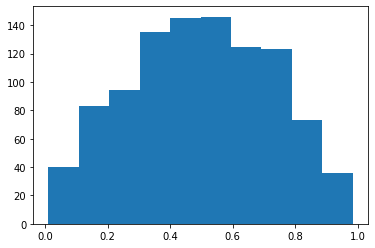

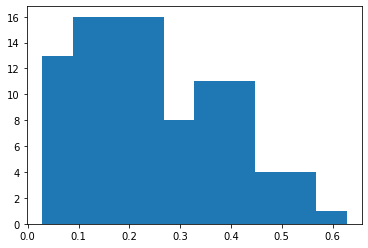

In [107]:
import scipy.stats as st

print(st.t.interval(alpha = 0.99, df = len(total_med_coef)-1, loc = np.mean(total_med_coef), scale = st.sem(total_med_coef)))
print(st.t.interval(alpha = 0.99, df = len(winner_med)-1, loc = np.mean(winner_med), scale = st.sem(winner_med)) )

#st.t.interval(alpha = 0.99, def = len(total_med_coef) - 1, loc = np.mean(total_med_coef))

#print(st.t.interval(alpha = 0.99, def = len(winner) - 1, loc = np.mean(winner), scale = st.sem(winner)))


plt.hist(total_med_coef)
plt.show()

plt.hist(winner_med)  #   Медицина побеждает
plt.show()


#  Нормировать количество выживших на окличество обратившихся


## От чего зависит выживаемость НКО?

- График. Сколько кругов смогла пройти организация? И коэффициенты расходов. Сделать 100 симуляций
- Проверить код, точно ли пациенты не идут в мертвые организации
- Предпочтения пациентов. Расходы на пиар в компании и общее количеств вылеченных пациентов. График. Количество выживших пациентов на количество раундов. 

Возможно, выживают лучше организации, которые тратят больше денег на пиар.

- Планы на будущее: сетевые взаимосвязи между пациентами. Граф. Как влияют слухи и социальные связи на организации.
- Эндогенизация правила принятия решений и стратегий.
- Подумать, может, оставлять пациентов на несколько кругов. Каких пациентов оставляем из тех, кто не вылечился. 
- Разные типы диагнозы, возможно, имеют разные значимости для организаций. Дополнительная информация о пациентах. Возраст. Организация может специализироваться на одну возрастную группу или на всех людей.


Если органиазция не берёт пациента, то можно потратить деньги на рекламу или на другого пациента, чтобы выжило большее количество пациентов.


Эффект обучения для донора и для органиазации. Получил сигнал, пожертвовал в раунде органиазации. 

1. Внести коэффициент: какой организации уже жертвовал. Той организации, которой он пожертвовал, тем меньше дисперсии. Об этой организации. Можно сделать дисперсию = 9 / (количество раундов, которой он жертвовал этой организации + 1)

2. Как включить слухи? Вот у нас есть пациенты. Генерируем случайный граф. С помощью Бернулли. Какой коэффициент р? возьмём сейчас 1/2. Можем помоделировать с разными p. Можно сделать двумерное binomial. Эффект репутации можем размножить

Репутационный эффект надо измерять в раунде n+1. А может не только ближайший круг получает сведения? Ближайшее окружение получает чистый сигнал. А вот в дальнейшем получат сигнал репутационный 1/2 или там (1/2)^k, k - количество рёбер между пациентами. 

Пока смотрим ближайшее окружение. 

А что если пациенты будут выживать 